In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
from astropy import constants as const
from matplotlib import gridspec
import matplotlib
from tqdm import tqdm_notebook
from astropy.table import Table
from astropy import units
from scipy.signal import medfilt
from matplotlib.colors import LogNorm

# nicer looking plots
import matplotlib as mpl
#reload(ms)
mpl.rcParams['xtick.labelsize']=18
mpl.rcParams['ytick.labelsize']=18
#plt.rc('text', usetex=True)
#plt.rc('font', family='serif')


%matplotlib inline

from pylab import *
colormap='inferno'

cmap = cm.get_cmap(colormap, 256)
colors = []
for i in range(cmap.N):
    rgb = cmap(i)[:3]
    colors.append(matplotlib.colors.rgb2hex(rgb))
colors = np.array(colors)


COLOR = 'k'
plt.rcParams['font.size'] = 20
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

plt.rcParams['xtick.major.width'] = 3
plt.rcParams['ytick.major.width'] = 3
plt.rcParams['xtick.major.size']  = 12 #12
plt.rcParams['ytick.major.size']  = 12 #12

plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.minor.size']  = 8
plt.rcParams['ytick.minor.size']  = 8

plt.rcParams['axes.linewidth'] = 3

plt.rcParams['font.size'] = 20
plt.rcParams['text.color'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
#plt.rcParams['axes.spines.top'] = False
#plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['axes.edgecolor'] = COLOR
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['legend.facecolor'] = 'none'

In [2]:
path = '/Users/arcticfox/Documents/AUMic/atm_model_output/'

spec_b = np.loadtxt(path+'au_mic_b.dat', skiprows=2)
spec_c = np.loadtxt(path+'au_mic_c.dat', skiprows=2)

equil_spec_b = np.loadtxt(path+'equil_au_mic_b_spectrum.dat', skiprows=2)
equil_spec_c = np.loadtxt(path+'equil_au_mic_c_spectrum.dat', skiprows=2)

In [3]:
keys = np.array(['o2', 'nh3', 'h2o', 'ch4', 'co2', 'co'])
labels = np.array([r'O$_2$', r'NH$_3$', r'H$_2$O', r'CH$_4$', r'CO$_2$', 'CO', r'O$_3$'])

plot_colors = colors[np.linspace(0,230,len(keys)+1, dtype=int)]
plot_colors = colors[np.array([ 0,  50,  90, 135, 180, 215, 230],dtype=int)]

In [9]:
tab_b = Table.read(path+'au_mic_b_vert_profs.dat', format='ascii')
tab_c = Table.read(path+'au_mic_c_vert_profs.dat', format='ascii')

equil_tab_b = Table.read(path+'equil_au_mic_b_vert_profs.dat', format='ascii')
equil_tab_c = Table.read(path+'equil_au_mic_c_vert_profs.dat', format='ascii')

In [10]:
lambdas= np.array([[0.7744270205066344, 1.4402895054282265],
                   [2.0579010856453555, 2.405307599517491],
                   [2.636911942098914, 2.965018094089264],
                   [3.1773220747889024, 3.8914354644149576],
                   [4.171290711700844, 4.509047044632087],
                   [4.721351025331725, 5.049457177322074],
                   [5.3486127864897455, 6.805790108564535],
                   [7.259348612786489, 7.9831121833534375],
                   [9.440289505428227, 9.980699638118214]
                   ])
lambdas *= 10**4
lambda_labels = np.array(['h2o', 'ch4', 'co2', 'ch4', 'co2', 'o3', 'h2o', 'ch4', 'o3'])

In [11]:
def plot_table(tab, ax, colors, label=False, linestyle='-'):
    global keys, labels
    for i, k in enumerate(keys):
        if label:
            ax.plot(tab[k], tab['press'], colors[i], lw=4, 
                    label=labels[i], linestyle=linestyle)
        else:
            ax.plot(tab[k], tab['press'], colors[i], lw=4, linestyle=linestyle)
    return

def plot_hlines(ax, y, xoffset=-0.01, yoffset=0.01):
    global lambdas, lambda_labels, keys, plot_colors, labels
    
    for i in range(len(lambdas)):
        arg = np.where(keys==lambda_labels[i])[0]
        if len(arg)>0:
            ax.hlines(y, 
                      lambdas[i][0], 
                      lambdas[i][1], lw=4, 
                      color=plot_colors[arg])
            ax.text(x=np.nansum(lambdas[i])/2+xoffset[i], 
                    y=y+yoffset,
                    s=labels[arg[0]], color=plot_colors[arg[0]])
    return

def plot_o3(ax, y, xoffset=-0.01, yoffset=0.01):
    global lambdas, lambda_labels, keys, plot_colors, labels
    for i in np.where(lambda_labels=='o3')[0]:
        ax.hlines(y, 
                  lambdas[i][0], 
                  lambdas[i][1], lw=4, 
                  color=plot_colors[-1])
        ax.text(x=np.nansum(lambdas[i])/2+xoffset[i], 
                y=y+yoffset,
                s=labels[-1], color=plot_colors[-1])
    return

def plot_spectrum(equil, disequil, ax, label=False, alpha=0.3, ks=31, lw=3):
    global sc, esc
    if label:
        ax.plot((equil[:,0]*units.m).to(units.AA), 
                medfilt(equil[:,1], ks), c=esc, lw=lw,
                label='Equilibrium Profile', zorder=10)
        ax.plot((disequil[:,0]*units.m).to(units.AA), 
                medfilt(disequil[:,1], ks), c=sc, lw=lw, 
                label='Disequilibrium Profile', zorder=10)
        
    else:
        ax.plot((equil[:,0]*units.m).to(units.AA), 
            medfilt(equil[:,1], ks), c=esc, lw=lw, zorder=10)
        ax.plot((disequil[:,0]*units.m).to(units.AA), 
                medfilt(disequil[:,1], ks), lw=lw, 
                c=sc, zorder=10)
        
    ax.plot((disequil[:,0]*units.m).to(units.AA), 
             disequil[:,1], c='#969594', alpha=0.65)
    ax.plot((equil[:,0]*units.m).to(units.AA), 
             equil[:,1], c=esc, alpha=0.4)
    
        
    return

/var/folders/gz/h7_ym7m52dlgq4xpllc1x3m40000gn/T/ipykernel_11718/1681274371.py:81: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('/Users/arcticfox/Documents/AUMic/paper/transmission.pdf', dpi=300,


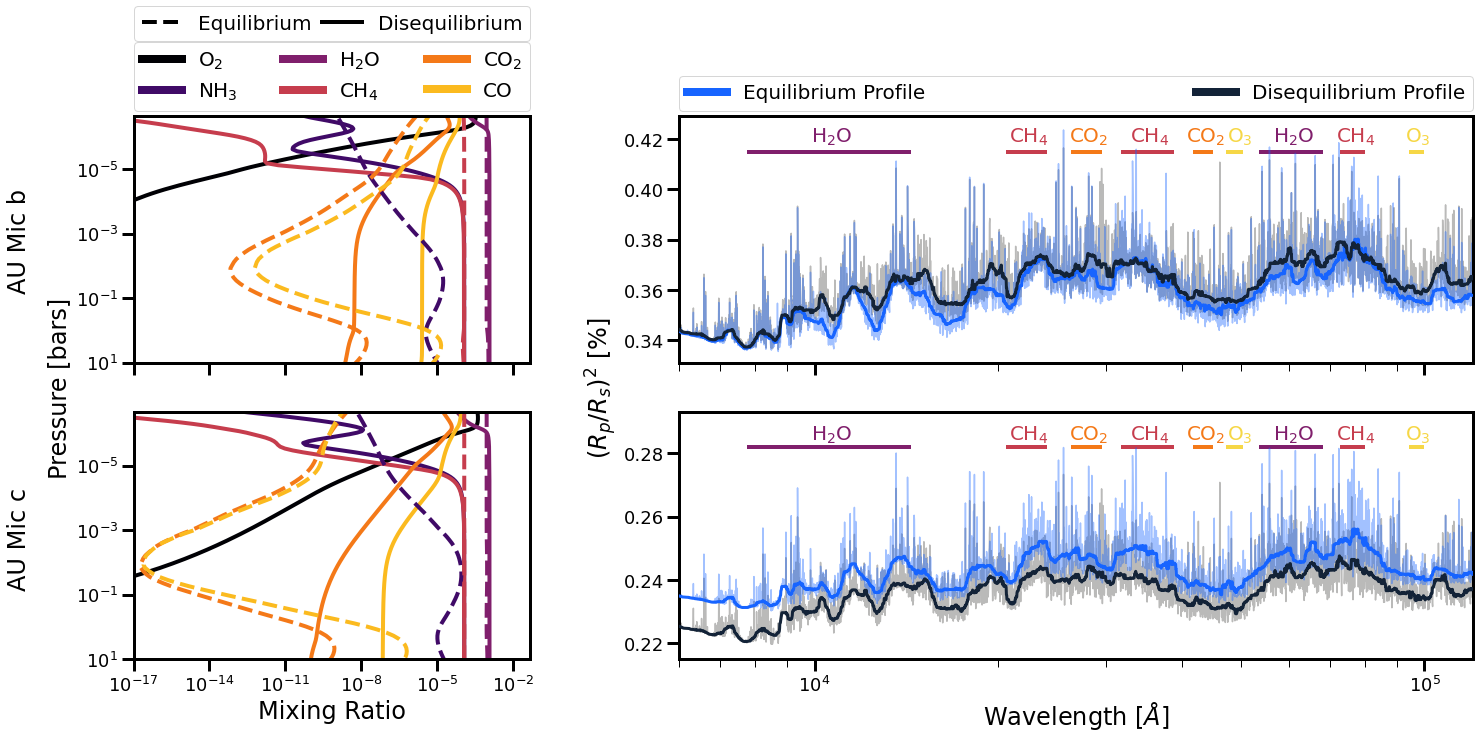

In [21]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2,
                                             figsize=(24,10), 
                                             gridspec_kw={'width_ratios':[1,2]})
fig.set_facecolor('w')

sc = '#132338'
esc = '#1764ff'

plot_spectrum(equil_spec_b, spec_b, ax2, label=True)
plot_spectrum(equil_spec_c, spec_c, ax4)
lgd = ax2.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
                 ncol=2, mode="expand", borderaxespad=0.)
for handle in lgd.legendHandles:
    handle.set_linewidth(8)

plot_table(tab_b, ax1, colors=plot_colors, label=True)
plot_table(tab_c, ax3, colors=plot_colors)

plot_table(equil_tab_b, ax1, colors=plot_colors, linestyle='--')
plot_table(equil_tab_c, ax3, colors=plot_colors, linestyle='--')

lgd = ax1.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
                 ncol=3, mode="expand", borderaxespad=0.)
for handle in lgd.legendHandles:
    handle.set_linewidth(8)


twin = ax1.twinx()
twin.plot(np.linspace(-1,0,2), np.ones(2), 'k--', label='Equilibrium')
twin.plot(np.linspace(-1,0,2), np.ones(2), 'k', label='Disequilibrium')
twinlgnd = twin.legend(bbox_to_anchor=(0., 1.3, 1., .102), loc=3,
                       ncol=3, mode="expand", borderaxespad=0.)
for handle in twinlgnd.legendHandles:
    handle.set_linewidth(4)


y = [np.full(len(lambdas), 0.415), 0.282]
xoffset = np.array([-1200, -1500, -1900, -2400, -2800, -2800, -4300, -4600])
for i,ax in enumerate([ax2,ax4]):
    plot_hlines(ax, y=[0.415, 0.282][i], 
                yoffset=[0.004, 0.0023][i],
                xoffset=xoffset)
    plot_o3(ax, y=[0.415, 0.282][i], 
            yoffset=[0.004, 0.0023][i],
            xoffset=np.array([0,0,0,0,0,-1400,0,0,-4300]))

    
ax3.set_xlabel('Mixing Ratio', fontsize=24)
ax4.set_xlabel('Wavelength [$\AA$]', fontsize=24)
ax3.set_ylabel('Pressure [bars]', fontsize=24, y=1.1)
ax4.set_ylabel('($R_p/R_s)^2$ [%]', fontsize=24, y=1.1)

for i, ax in enumerate([ax2, ax4]):
    ax.set_xscale('log')
    ax.set_xlim(6e3,1.2e5)
    if i == 0:
        ax.set_xticklabels([])
    else:
        xticks = np.linspace(1e4,1e5,6)

for ax in [ax1, ax3, twin]:
    ax.set_xlim(1e-17, 0.05)
    ax.set_ylim(10, 2.2e-7)
    ax.set_xscale('log')
    ax.set_yscale('log')
ax1.set_xticklabels([])
ax2.set_xticklabels([])
twin.set_yticks([])
twin.set_xticklabels([])

ax4.set_ylim(0.215, 0.293)
    
for i,ax in enumerate([ax1, ax3]):
    if i==1:
        s='AU Mic c'
    else:
        s='AU Mic b'
    ax.text(s=s, x=10e-23, y=5e-2, rotation=90, fontsize=24)

fig.subplots_adjust(wspace=0.25)
plt.savefig('/Users/arcticfox/Documents/AUMic/paper/transmission.pdf', dpi=300,
            rasterize=True, bbox_inches='tight')
#plt.savefig('/Users/arcticfox/Desktop/transmission.png', dpi=300,
#            rasterize=True, bbox_inches='tight')

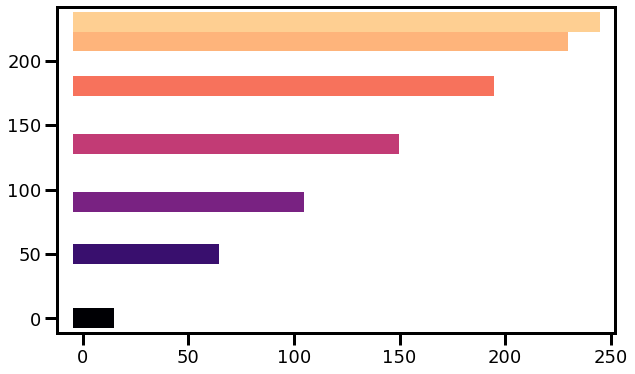

In [8]:
from pylab import *
colormap='magma'

cmap = cm.get_cmap(colormap, 256)
colors = []
for i in range(cmap.N):
    rgb = cmap(i)[:3]
    colors.append(matplotlib.colors.rgb2hex(rgb))
colors = np.array(colors)

plt.figure(figsize=(10,6))
for i in np.array([  0,  50,  90, 135, 180, 215, 230],dtype=int):
    plt.plot(np.linspace(0,i+10, 5), np.full(5, i), c=colors[i], lw=20)